#Kaggle API

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

Dataset URL: https://www.kaggle.com/datasets/pcbreviglieri/pneumonia-xray-images
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 1.14G/1.14G [00:17<00:00, 283MB/s]
100% 1.14G/1.14G [00:17<00:00, 72.0MB/s]


In [3]:
import zipfile

zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# 1 Set up

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1.1 Define Constants

In [5]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [6]:

#Define standard parameter values
batch_size = 16
img_height = 500
img_width = 500


# 2 Preparing Data

## 2.2 Image Data Augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,

                               )

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [8]:
type(train)

keras.src.legacy.preprocessing.image.DirectoryIterator

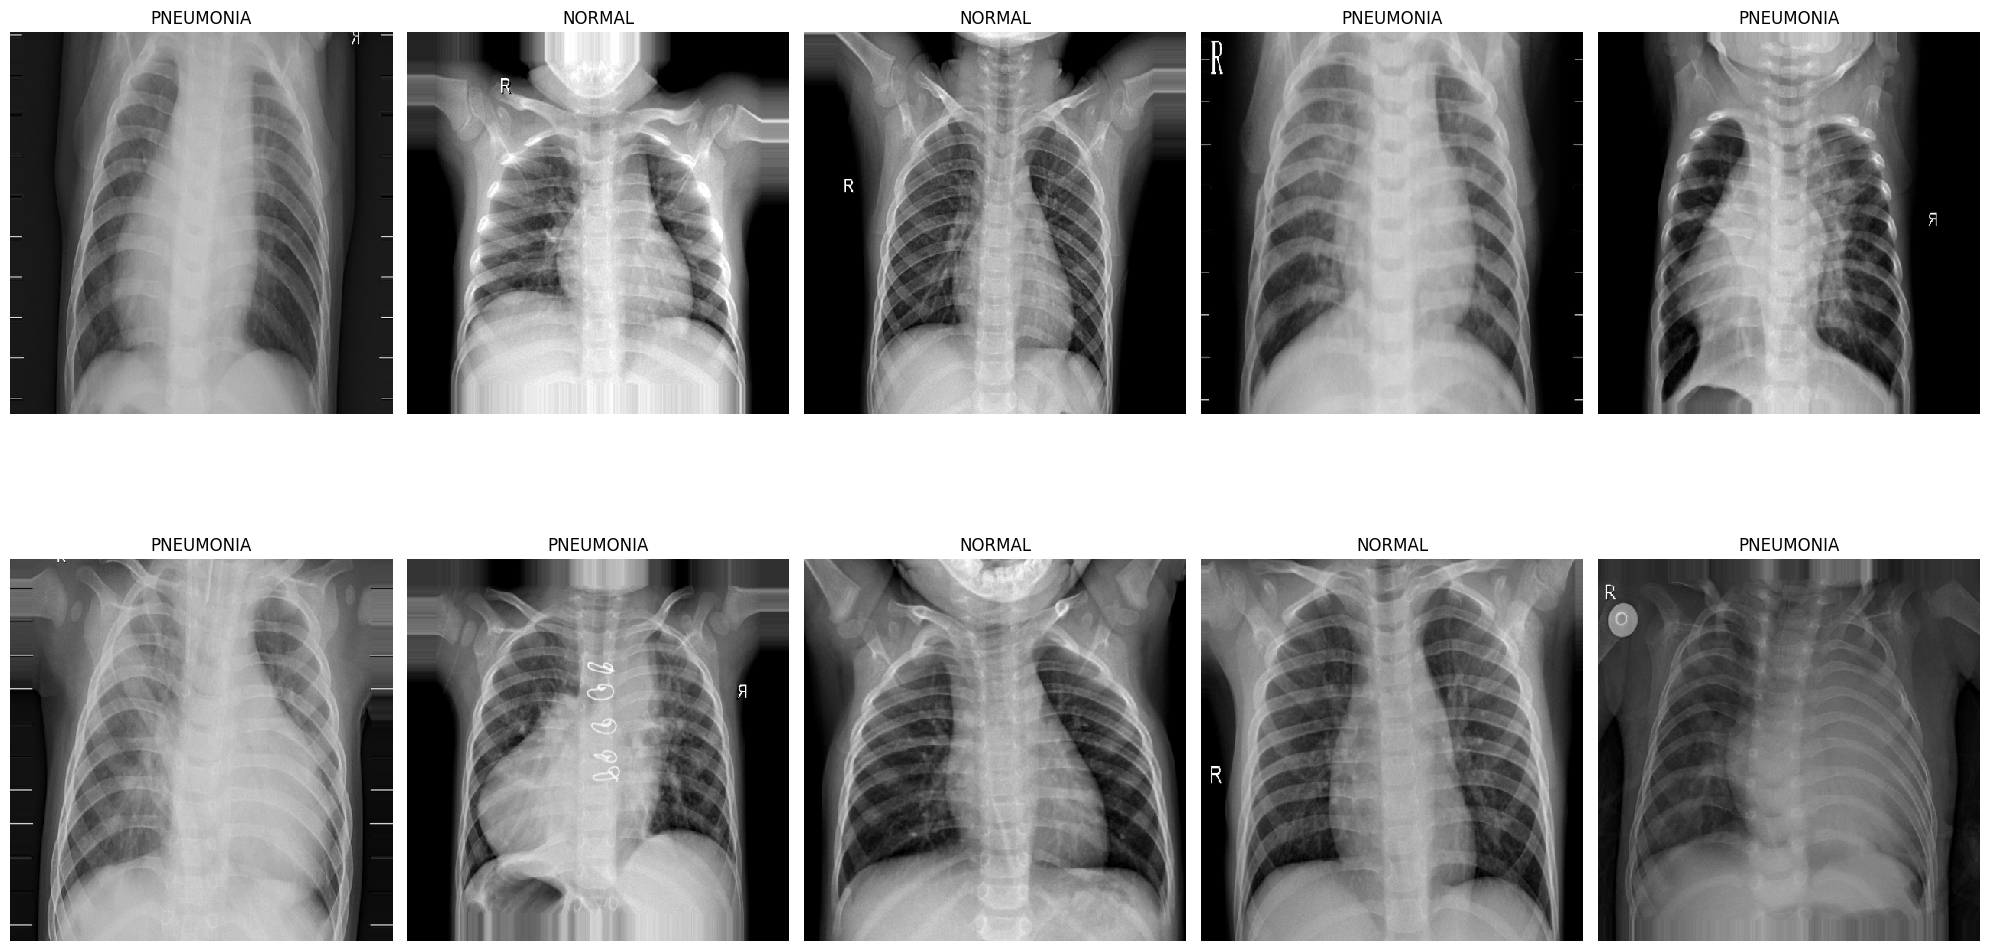

In [9]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

### Define

In [10]:
featurewise_center=False,  # set input mean to 0 over the dataset
samplewise_center=False,  # set each sample mean to 0
featurewise_std_normalization=False,  # divide inputs by std of the dataset
samplewise_std_normalization=False,  # divide each input by its std
zca_whitening=False,  # apply ZCA whitening

rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
zoom_range = 0.2, # Randomly zoom image
width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
horizontal_flip = True,  # randomly flip images
vertical_flip=False,# randomly flip images
shear_range=0.2,
brightness_range=(1.2, 1.5)

# 3 Tensorflow - Keras

In [11]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 3.1 Convolutional Neural Network Model

In [12]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 32)        0

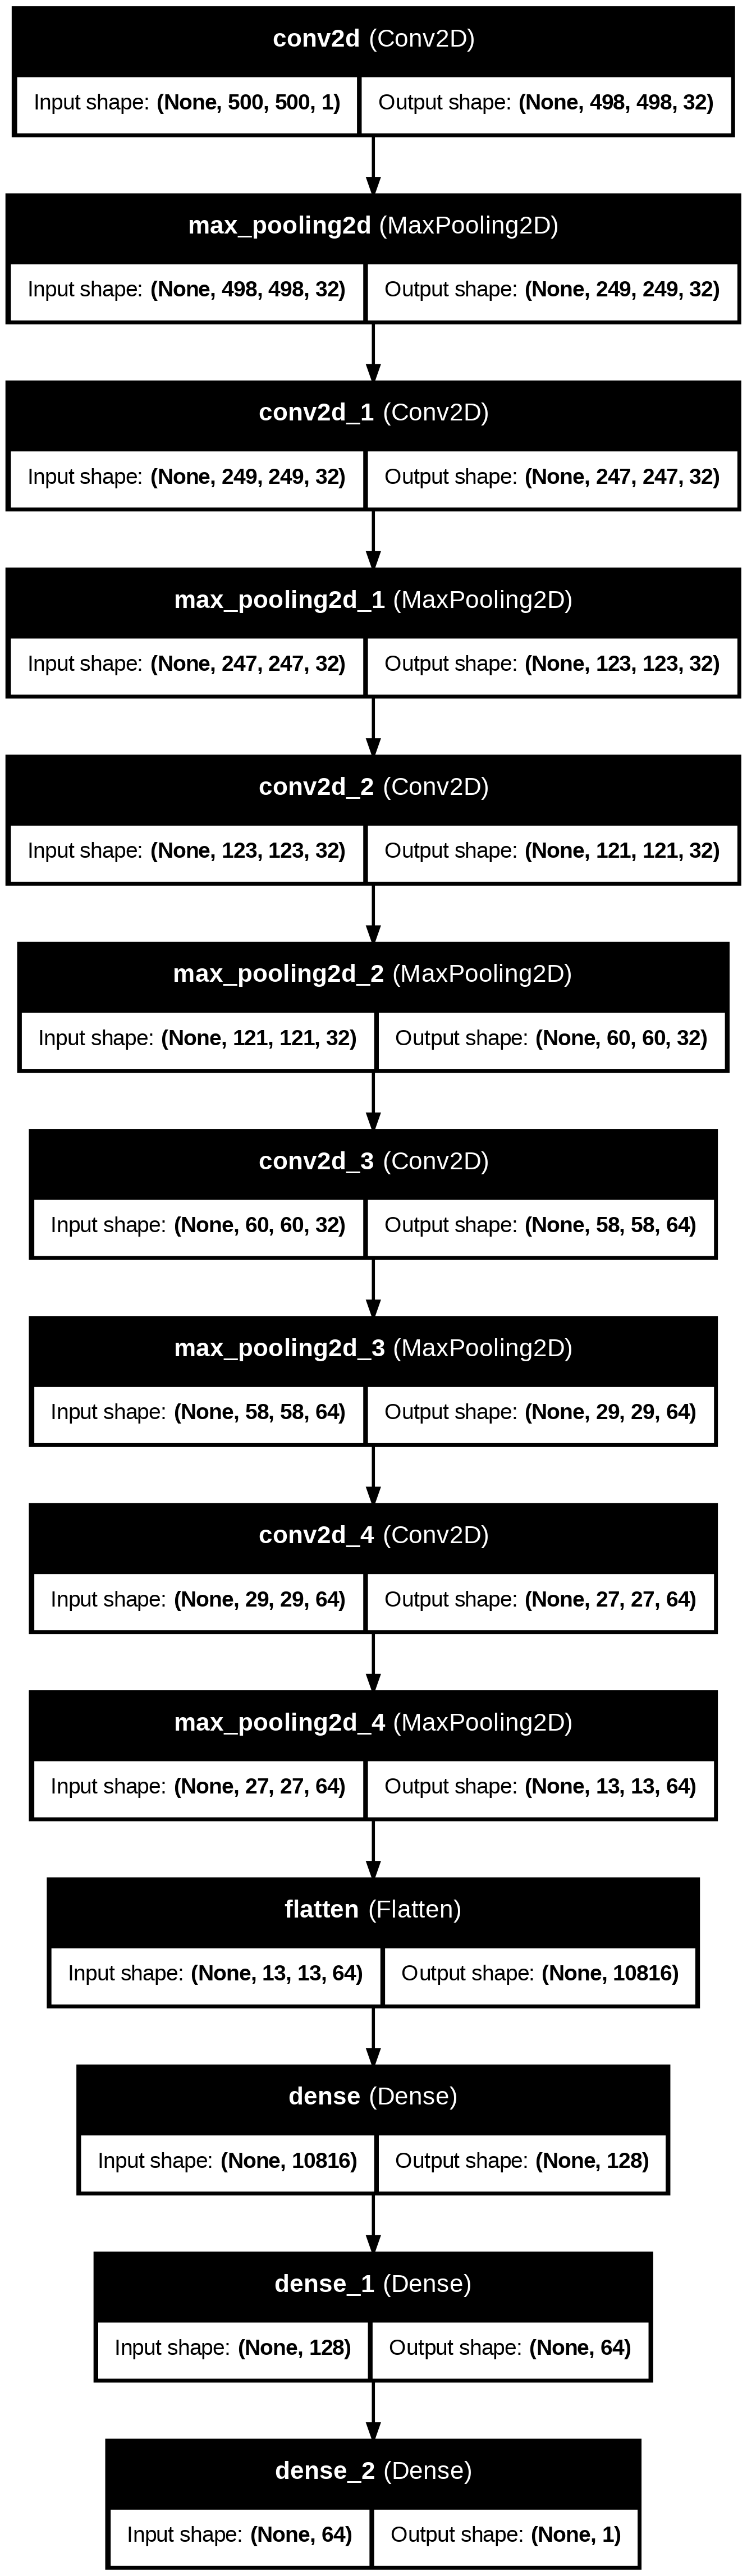

In [13]:
!pip install pydot
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

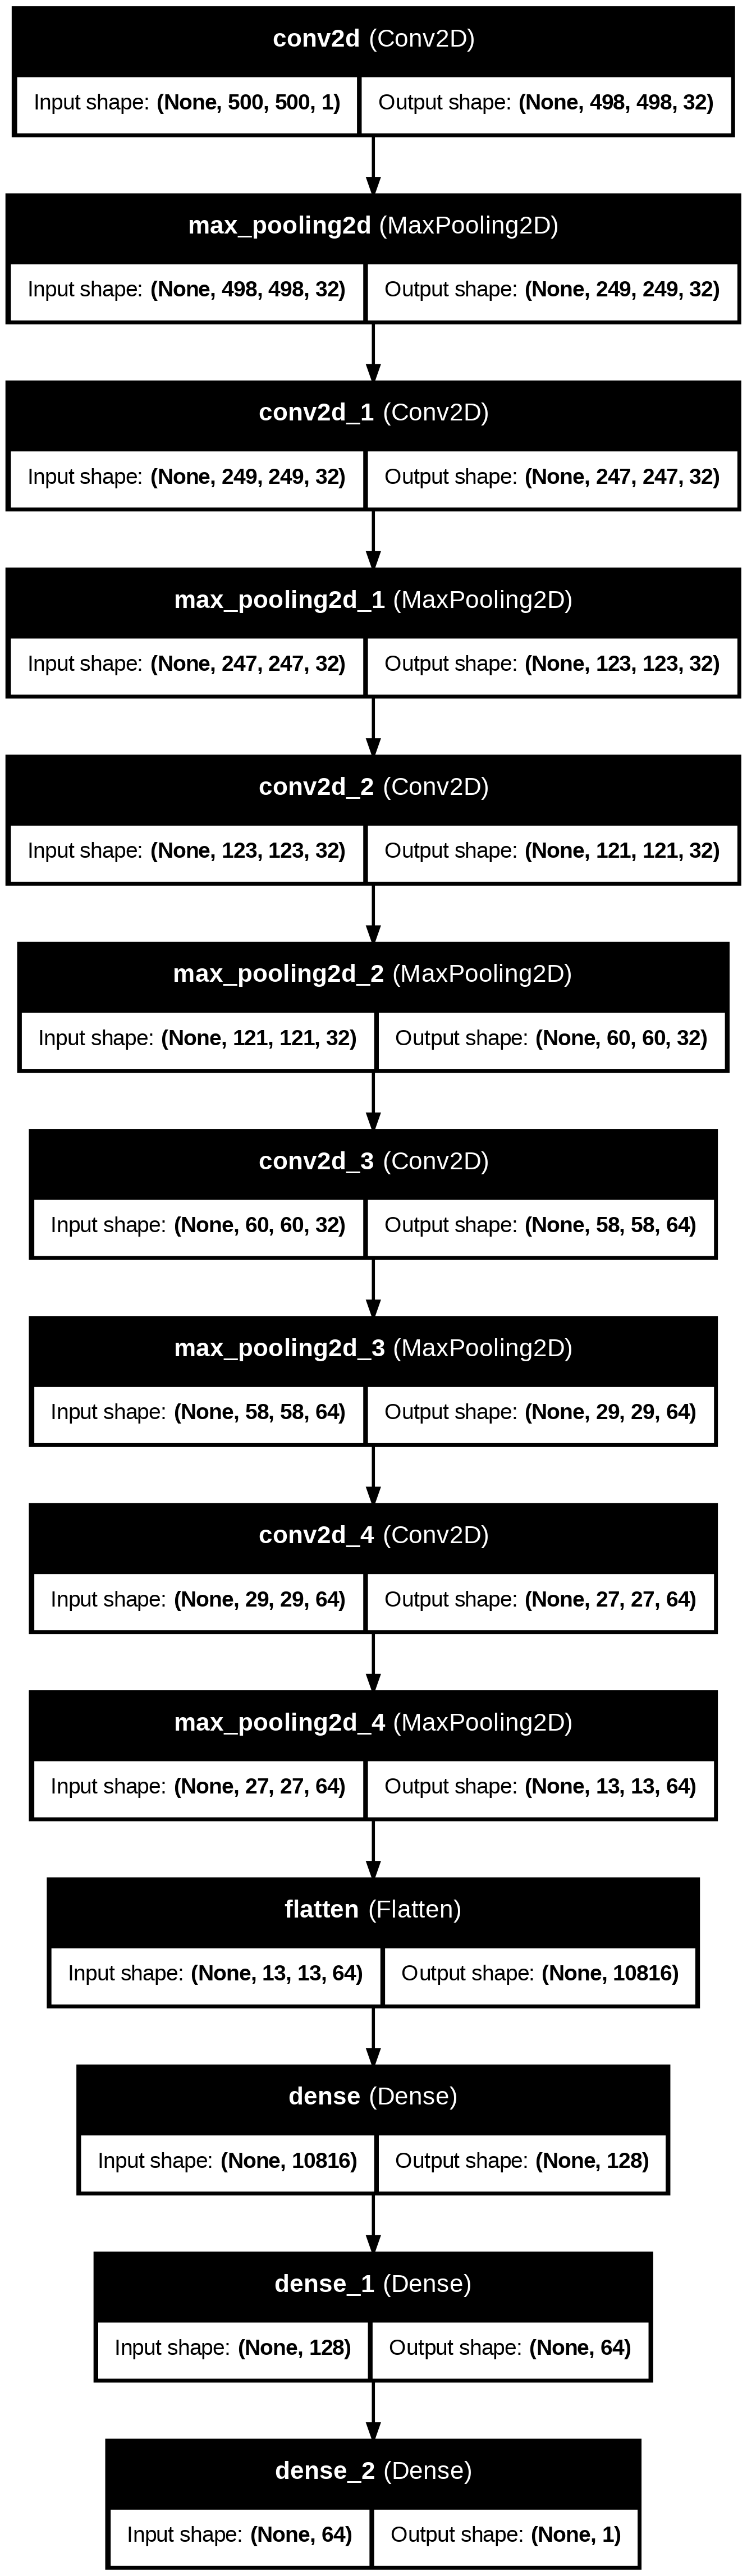

In [14]:
!pip install graphviz
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 3.2 Fit Model

In [15]:
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [16]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train.classes),
                                        y = train.classes
                                    )
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{np.int32(0): np.float64(1.9371534195933457), np.int32(1): np.float64(0.6739549839228296)}


In [31]:
cnn.fit(train,epochs=1, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.8784 - loss: 0.2815

/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


262/262 ━━━━━━━━━━━━━━━━━━━━ 137s 520ms/step - accuracy: 0.8785 - loss: 0.2814 - val_accuracy: 0.8779 - val_loss: 0.2719 - learning_rate: 0.0010


In [32]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [33]:
fp = "/content/cnn_pneu_vamp_model.h5"
cnn.save(fp)

In [34]:
cnn = load_model(fp)
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [35]:
#cnn.predict_segmentation()
preds=cnn.predict
pred=np.argmax(preds)
print(preds)
print(pred)

<bound method TensorFlowTrainer.predict of <Sequential name=sequential, built=True>>
0


##3.3 Evaluation

In [37]:
pd.DataFrame(history.history).plot()

NameError: name 'history' is not defined

In [38]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8861 - loss: 0.3025
The testing accuracy is : 87.17948794364929 %


In [39]:
preds = cnn.predict(test,verbose=1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step


In [40]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

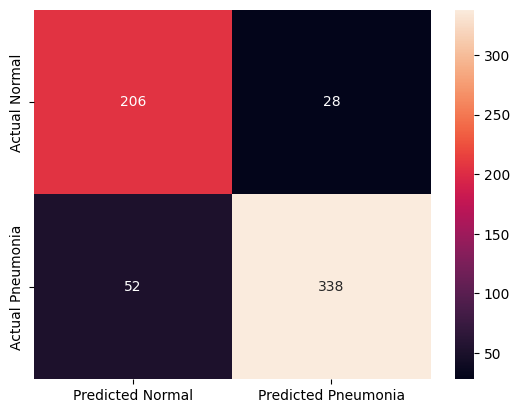

In [41]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [42]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.80      0.88      0.84       234
   PNEUMONIA       0.92      0.87      0.89       390

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.87       624
weighted avg       0.88      0.87      0.87       624



In [45]:
test.reset()
x_batches = []
y_batches = []
for i in range(len(test)):
    img_batch, label_batch = next(test)
    x_batches.append(img_batch)
    y_batches.append(label_batch)

x = np.concatenate(x_batches)
y = np.concatenate(y_batches)

print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


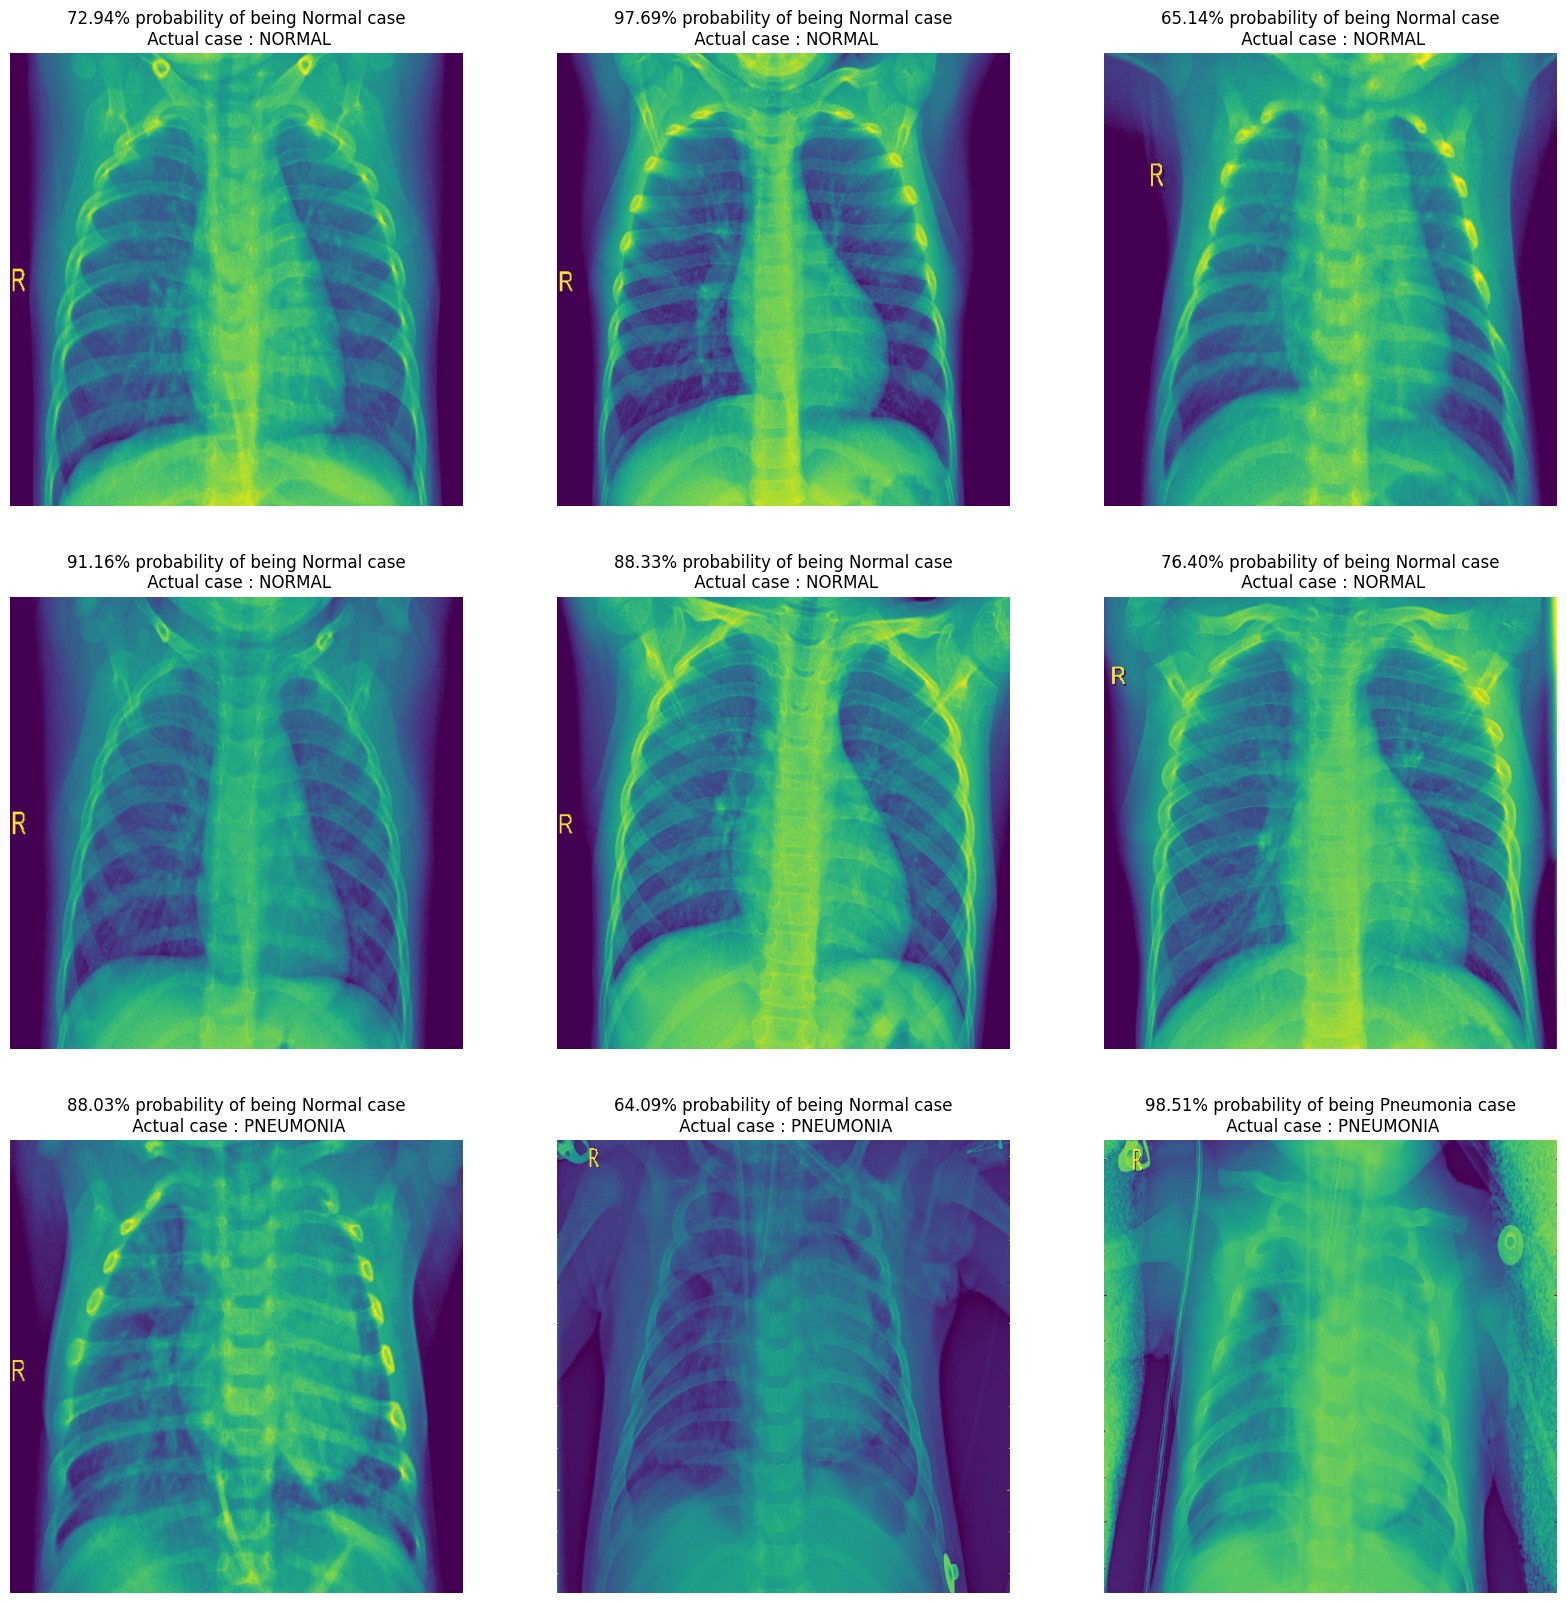

In [46]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5:
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))


  else:
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))



  plt.title(out+"\n Actual case : "+ dic.get(y[i]))
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [47]:
import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=y ) )
fig.show()

In [48]:
import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=predictions[:,0] ) )
fig.show()

# Run streamlit app from a Google Colab Notebook


In [53]:
!pip install -q streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 122.6 MB/s eta 0:00:00


In [54]:
!pip install h5py

Reset the execution environment after streamlit installation

## Download a streamlit app example

This example comes from [How to Build a Simple Machine Learning Web App in Python](https://www.youtube.com/watch?v=8M20LyCZDOY) and it will create a **Simple Iris Flower Prediction App**

In [55]:
!wget https://raw.githubusercontent.com/smarthardik10/Medical-X-ray-Image-Classification-using-Convolutional-Neural-Network/main/webapp.py

--2025-10-31 19:23:16--  https://raw.githubusercontent.com/smarthardik10/Medical-X-ray-Image-Classification-using-Convolutional-Neural-Network/main/webapp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1607 (1.6K) [text/plain]
Saving to: ‘webapp.py’

webapp.py           100%[===================>]   1.57K  --.-KB/s    in 0s      

2025-10-31 19:23:16 (35.4 MB/s) - ‘webapp.py’ saved [1607/1607]



## OR

## Install ngrok

In [56]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2025-10-31 19:23:35--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 13.248.244.96, 75.2.60.68, 35.71.179.82, ...
Connecting to bin.equinox.io (bin.equinox.io)|13.248.244.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  4.74MB/s    in 2.8s    

2025-10-31 19:23:39 (4.74 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]



In [57]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [58]:
%%writefile webapp.py
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import tensorflow as tf

from tempfile import NamedTemporaryFile
from tensorflow.keras.preprocessing import image

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)

def loading_model():
  fp = "cnn_pneu_vamp_model.h5"
  model_loader = load_model(fp)
  return model_loader

cnn = loading_model()
st.write("""
# X-Ray Classification (Pneumonia/Normal)
""")






temp = st.file_uploader("Upload X-Ray Image")

buffer = temp
temp_file = NamedTemporaryFile(delete=False)
if buffer:
    temp_file.write(buffer.getvalue())
    st.write(image.load_img(temp_file.name))


if buffer is None:
  st.text("Oops! that doesn't look like an image. Try again.")

else:



  hardik_img = image.load_img(temp_file.name, target_size=(500, 500),color_mode='grayscale')

  # Preprocessing the image
  pp_hardik_img = image.img_to_array(hardik_img)
  pp_hardik_img = pp_hardik_img/255
  pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)

  #predict
  hardik_preds= cnn.predict(pp_hardik_img)
  if hardik_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))

  else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))

  st.success(out)

  image = Image.open(temp)
  st.image(image,use_column_width=True)








Overwriting webapp.py


In [59]:
get_ipython().system_raw('./ngrok http 8501 &')

In [60]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

/bin/bash: -c: line 1: syntax error near unexpected token `"Execute the next cell and the go to the following URL: "'
/bin/bash: -c: line 1: `curl -s http://localhost:4040/api/tunnels | python3 -c \'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])''


In [ ]:
!streamlit run /content/webapp.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.157.226:8501



[![ko-fi](https://www.ko-fi.com/img/githubbutton_sm.svg)](https://ko-fi.com/Y8Y3VYYE)